# Give Me Some Credit
![](https://www.freshfacs.com/v/vspfiles/photos/D3-2.jpg)
Improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years.


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

##### Around 6% of samples defaulted
- MonthlyIncome and NumberOfDependents have 29731 (19.82%) and 3924 (2.61%) null values respectively
- We also notice that when NumberOfTimes90DaysLate has values above 17, there are 267 instances where the three columns 
- NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse share the same values, specifically 96 and 98.
    - We can see that sharing the same values of 96 and 98 respectively is not logical since trivial calculations can reveal that being 30 days past due for 96 times for a single person within a timespan of 2 years is not possible.
- RevolvingUtilizationOfUnsecuredLines
    - Defined as ratio of the total amount of money owed to total credit limit
distribution of values is right-skewed, consider removing outliers
    - It is expected that as this value increases, the proportion of people defaulting should increase as well
    - However, we can see that as the minimum value of this column is set to 13, the proportion of defaulters is smaller than that belonging to the pool of clients with total amount of money owed not exceeding total credit limit.
    - Thus we should remove those samples with RevolvingUtilizationOfUnsecuredLines's value more than equal to 13
- age
    - There seems to be more younger people defaulting and the distribution seems fine on the whole
- NumberOfTimes90DaysLate
    - It is interesting to note that there are no one who is 90 or more days past due between 17 and 96 times.
- NumberOfTime60-89DaysPastDueNotWorse
    - It is interesting to note that there are no one who is 60-89 days past due between 11 and 96 times.
- NumberOfTime30-59DaysPastDueNotWorse
    - It is interesting to note that there are no one who is 30-59 days past due between 13 and 96 times.
- DebtRatio
    - 2.5% of clients owe around 3490 or more times what they own
    - For the people who have monthly income in this 2.5%, only 185 people have values for their monthly incomes and the values are either 0 or 1.
    - There are 164 out of these 185 people who are of two different types, first with no monthly income and does not default and second with monthly income and does default.
- MonthlyIncome
    - Distribution of values is skewed, we can consider imputation with median.
    - We can also consider imputing with normally distributed values with its mean and standard deviation.
- Numberof Dependents
    - We can consider imputing with its mode, which is zero.

# Imports

In [17]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import HTML

pd.set_option('max_columns', 50)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, auc
from sklearn import model_selection

In [25]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb


In [26]:
def evalBinaryClassifier(model, x, y, labels=['Positives','Negatives']):
    '''
    source: https://towardsdatascience.com/how-to-interpret-a-binary-logistic-regressor-with-scikit-learn-6d56c5783b49
    Visualize the performance of  a Logistic Regression Binary Classifier.
    
    Displays a labelled Confusion Matrix, distributions of the predicted
    probabilities for both classes, the ROC curve, and F1 score of a fitted
    Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts
    
    Parameters
    ----------
    model : fitted scikit-learn model with predict_proba & predict methods
        and classes_ attribute. Typically LogisticRegression or 
        LogisticRegressionCV
    
    x : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples
        in the data to be tested, and n_features is the number of features
    
    y : array-like, shape (n_samples,)
        Target vector relative to x.
    
    labels: list, optional
        list of text labels for the two classes, with the positive label first
        
    Displays
    ----------
    3 Subplots
    
    Returns
    ----------
    F1: float
    '''
    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]
    
    #FIGURE
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y,model.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    printout = (
        f'Precision: {round(precision,2)} | '
        f'Recall: {round(recall,2)} | '
        f'F1 Score: {round(F1,2)} | '
    )
    print(printout)
    return F1

### Read Data

In [27]:
%%time
sampleEntry = pd.read_csv('sampleEntry.csv')
train = pd.read_csv('cs-training.csv')
test = pd.read_csv('cs-test.csv')

CPU times: user 172 ms, sys: 71.8 ms, total: 244 ms
Wall time: 265 ms


Variable Name	Description	Type
- ``SeriousDlqin2yrs``	Person experienced 90 days past due delinquency or worse	Y/N
- ``RevolvingUtilizationOfUnsecuredLines``	Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits	percentage
- ``age``	Age of borrower in years	integer
- ``NumberOfTime3059DaysPastDueNotWorse``	Number of times borrower has been 30-59 days past due but no worse in the last 2 years.	integer
- ``DebtRatio``	Monthly debt payments, alimony,living costs divided by monthy gross income	percentage
- ``MonthlyIncome``	Monthly income	real
- ``NumberOfOpenCreditLinesAndLoans``	Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)	integer
- ``NumberOfTimes90DaysLate``	Number of times borrower has been 90 days or more past due.	integer
- ``NumberRealEstateLoansOrLines``	Number of mortgage and real estate loans including home equity lines of credit	integer
- ``NumberOfTime60-89DaysPastDueNotWorse``	Number of times borrower has been 60-89 days past due but no worse in the last 2 years.	integer
- ``NumberOfDependents``	Number of dependents in family excluding themselves (spouse, children etc.)	integer

In [28]:
print('train shape  ',train.shape)

train shape   (150000, 12)


In [29]:
train.dtypes.value_counts()

int64      8
float64    4
dtype: int64

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [31]:
train = train.dropna()
train = train.drop(columns = ['Unnamed: 0'])
train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Data Duplicate Analysis

In [32]:
features = train.columns.values[0:30]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])

np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,9,7,0,3,10,8,6,1,2,5,4
Feature,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,SeriousDlqin2yrs,NumberOfTime30-59DaysPastDueNotWorse,NumberOfDependents,NumberRealEstateLoansOrLines,NumberOfOpenCreditLinesAndLoans,RevolvingUtilizationOfUnsecuredLines,age,MonthlyIncome,DebtRatio
Max duplicates,113994,113544,111912,99970,65456,43430,10810,7871,3217,2757,2491
Value,0,0,0,0,0,0,6,0,49,5000,0


### Value Counts Target - SeriousDlqin2yrs

In [33]:
train.SeriousDlqin2yrs.value_counts()

0    111912
1      8357
Name: SeriousDlqin2yrs, dtype: int64

### Feature Importance

In [34]:
train_X = train.drop(["SeriousDlqin2yrs"], axis=1)
train_y = np.log1p(train["SeriousDlqin2yrs"].values)

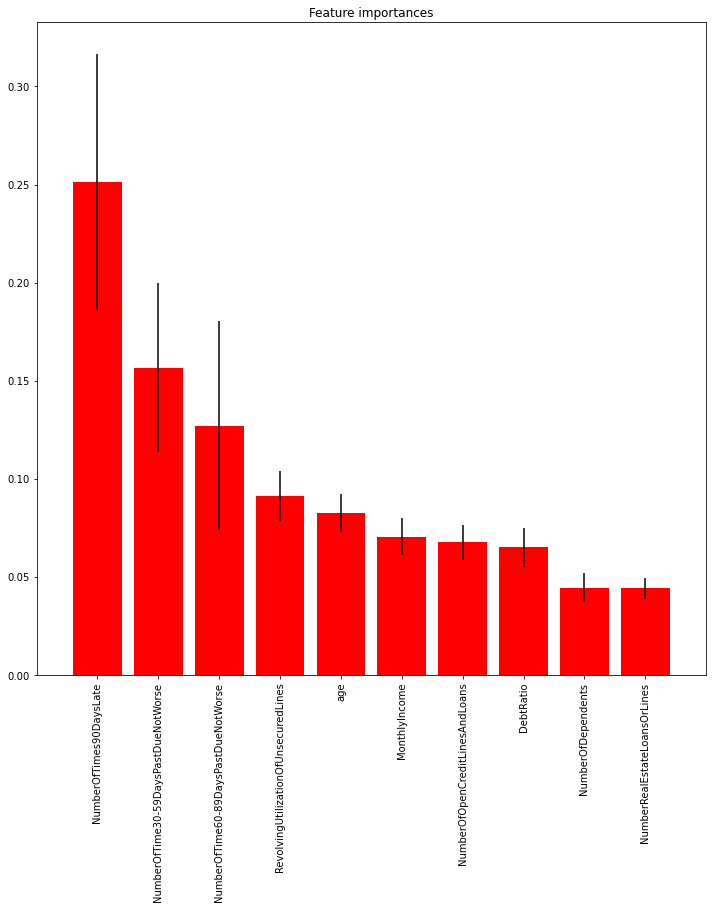

In [35]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plotando as importâncias ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [36]:
def plot_new_feature_distribution(df1, df2, label1, label2, features, n):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,n,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,n,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

# Baseline

In [37]:
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

In [38]:
def logistic(X,y):
    y_train=train['SeriousDlqin2yrs'].astype('uint8')
    X_train,X_test,y_train,y_test=train_test_split(train.drop('SeriousDlqin2yrs',axis=1),y_train,test_size=.2,random_state=2020)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    
    roc=roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    print('roc ',roc)

    return (prob[:,1],y_test)
y_train=train['SeriousDlqin2yrs'].astype('uint8')
probs,y_test=logistic(train.drop('SeriousDlqin2yrs',axis=1),y_train)

roc  0.647006290752698


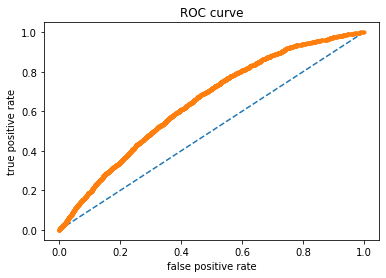

In [62]:
plot_roc(y_test,probs)

In [40]:

train_x, val_x, train_y, val_y=train_test_split(train.drop('SeriousDlqin2yrs',axis=1),y_train,test_size=.2,random_state=2020)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

In [41]:
rocrl=roc_auc_score(val_y, pred_y)
rocrl

0.5041934495861404

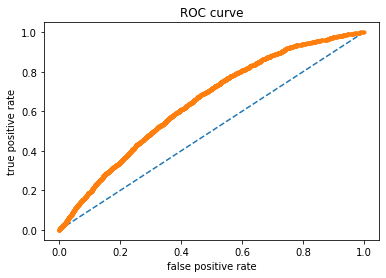

In [42]:
plot_roc(val_y, pred_y)

In [43]:
%%time
model = RandomForestClassifier(n_estimators=220).fit(train_x,train_y)
predictionforest = model.predict(val_x)

CPU times: user 30.6 s, sys: 341 ms, total: 30.9 s
Wall time: 31.2 s


In [44]:
%%time
rocrf=roc_auc_score(val_y, predictionforest)
print('roc ',rocrf)

roc  0.5852891566178565
CPU times: user 4.53 ms, sys: 1.59 ms, total: 6.12 ms
Wall time: 4.57 ms


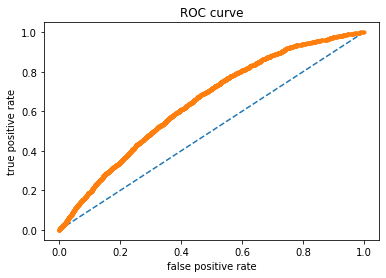

In [45]:
plot_roc(val_y, predictionforest)

In [46]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1, 
                            n_estimators = 220)

xgb_cfl.fit(train_x, train_y)
y_scorexgb = xgb_cfl.predict_proba(val_x)[:,1]

In [47]:
rocxgb=roc_auc_score(val_y, y_scorexgb)
print('roc ',rocxgb)

roc  0.8505855896829838


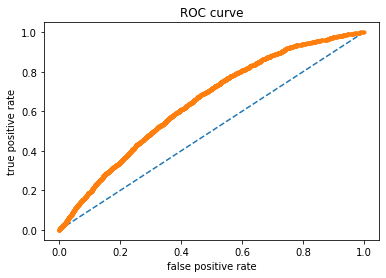

In [48]:
plot_roc(val_y, y_scorexgb)

# Grid Search CV 

###### XGB Classifier

In [49]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)
xgb_cfl.fit(train_x, train_y)
y_pred = xgb_cfl.predict(val_x)
y_score = xgb_cfl.predict_proba(val_x)[:,1]

In [50]:
%%time
param_grid = {
            'n_estimators': [50, 100, 200]
              }

CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, scoring ='roc_auc', verbose = 2)
CV_xgb_cfl.fit(train_x, train_y)

best_parameters = CV_xgb_cfl.best_params_
print("The best parameters: ", best_parameters)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. n_estimators=50, total=   1.8s
[CV] n_estimators=50 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] .................................. n_estimators=50, total=   1.7s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   1.8s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   1.8s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   1.8s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   3.5s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   3.4s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   3.6s
[CV] n_estimators=100 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.1min finished


The best parameters:  {'n_estimators': 50}
CPU times: user 8min 1s, sys: 13.5 s, total: 8min 15s
Wall time: 1min 7s


In [51]:
xgb_cfl2 = xgb.XGBClassifier(n_jobs = -1, 
                            n_estimators = 120)

xgb_cfl2.fit(train_x, train_y)
y_score2 = xgb_cfl2.predict_proba(val_x)[:,1]

In [52]:
rocxgb=roc_auc_score(val_y, y_score2)
print('roc ',rocxgb)

roc  0.8556019138284752


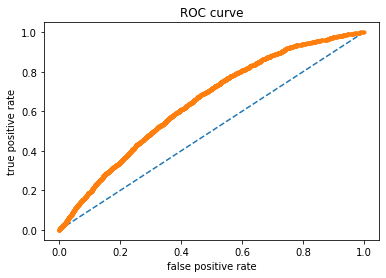

In [53]:
plot_roc(val_y, y_score2)

#### Score Analysis

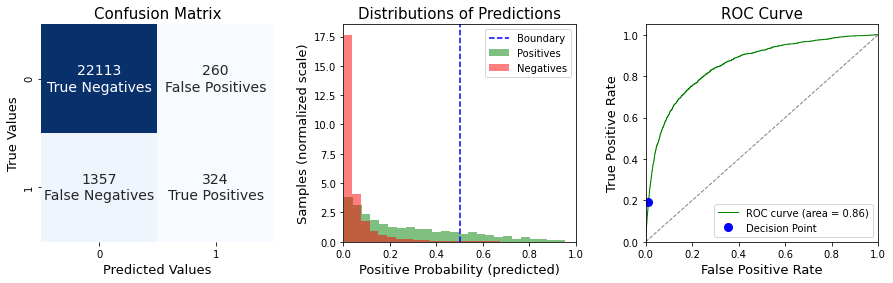

Precision: 0.55 | Recall: 0.19 | F1 Score: 0.29 | 


In [54]:
F1 = evalBinaryClassifier(xgb_cfl2, val_x, val_y)

Probability Analysis

count    1681.000000
mean        0.271728
std         0.233570
min         0.001551
25%         0.072179
50%         0.199104
75%         0.434366
max         0.953646
Name: Probability, dtype: float64


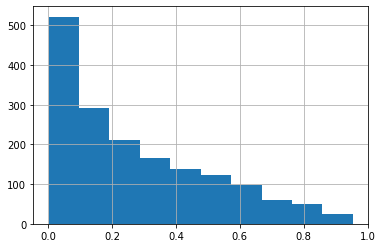

In [55]:
## Target 1
target1 = pd.DataFrame({"Target": val_y, 'Probability': y_score2 })
print(target1.loc[target1.Target == 1, 'Probability'].describe())
target1.loc[target1.Target == 1, 'Probability'].hist()


# Submission

In [56]:
test=test.drop(["SeriousDlqin2yrs","Unnamed: 0"],1)

In [57]:
res = xgb_cfl2.predict_proba(test)[:,1]
sampleEntry["Probability"]=res
sampleEntry.head()

,Id,Probability
0,1,0.040222
1,2,0.021043
2,3,0.023196
3,4,0.084662
4,5,0.105630


In [58]:
sampleEntry.to_csv("submission.csv",index=False)

## Deploy model using mia marketplace
![](https://miro.medium.com/max/1773/1*QuP5nFnvBNg-IrHvQ2-hCA.png)
mia is a platform for building and sharing machine learning apps


Mia Platform link, **Risk Models**: https://miamarketplace.com/pages/riskmodels

In [59]:
from platform import python_version
print(python_version())

3.8.3


XGBoost

In [60]:
test.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101503.000000,101503.000000,101503.000000,101503.000000,8.140000e+04,101503.000000,101503.000000,101503.000000,101503.000000,98877.000000
mean,5.310000,52.405436,0.453770,344.475020,6.855036e+03,8.453514,0.296691,1.013074,0.270317,0.769046
std,196.156039,14.779756,4.538487,1632.595231,3.650860e+04,5.144100,4.515859,1.110253,4.503578,1.136778
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030131,41.000000,0.000000,0.173423,3.408000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.152586,52.000000,0.000000,0.364260,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.564225,63.000000,0.000000,0.851619,8.200000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,21821.000000,104.000000,98.000000,268326.000000,7.727000e+06,85.000000,98.000000,37.000000,98.000000,43.000000


In [61]:
# save model to file
xgb_cfl2.save_model("model.bst")


# Final